# Ex1
# Team Members - Liron Cohen

# Q1 - Code and Algorithms



In [3]:
# First Part - The Algorithm
# This project is a Python implementation of a program that detects stars in two images and matches them based on their coordinates. At this project I used 2 diffrent ways for matching -
# 1- with RANSAC detection_stars.py file
# 2- Hungarian algorithm. secondWayMatching.py file *** NOTE : after many attempts, it sometimes work.

In [25]:
import os
import re
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import random
import math

In [24]:
def starsDetection(img):
    """
      Detect star-like bright objects in an image based on contours.

      Args:
          img (np.ndarray): BGR image.

      Returns:
          list: Detected star centers as (x, y, radius, brightness).
      """
    tmp_min = 0
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Apply a threshold to create a binary image
    ret, thresh = cv.threshold(img, 179, 255, cv.THRESH_BINARY)

    # Find contours in the binary image
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Loop through the contours and find the centers of the stars
    centers = []
    eps = 1 / 225000
    for cnt in contours:
        # Calculate the bounding box of the contour
        x, y, w, h = cv.boundingRect(cnt)

        # Check if the bounding box is too close to any of the previous centers
        too_close = False
        for center in centers:
            if abs(center[0] - x) < 50 and abs(center[1] - y) < 50:
                too_close = True
                break
        scale = img.shape[0] * img.shape[1] * eps
        if not too_close and max(w, h) < scale:
            # Calculate the center of the star
            center_x = x + w // 2
            center_y = y + h // 2
            brightness = img[center_y, center_x]
            centers.append((x, y, max(w, h), brightness))

    return centers

def initialDetection(img):
    """
    Perform initial detection of bright objects using thresholding and morphology.

    Args:
        img (np.ndarray): BGR image.

    Returns:
        list: Detected centers as (x, y, radius, brightness).
    """
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary image
    ret, thresh = cv.threshold(img, 160, 255, cv.THRESH_BINARY)

    # Apply morphological operations
    kernel = np.ones((6, 6), np.uint8)
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)

    # Find contours
    contours, hierarchy = cv.findContours(opening, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Loop through the contours and find the centers of the stars
    centers = []
    for cnt in contours:
        # Calculate the minimum enclosing circle of the contour
        (center_x, center_y), radius = cv.minEnclosingCircle(cnt)

        # Check if the center is too close to any of the previous centers
        too_close = False
        for center in centers:
            if abs(center[0] - center_x) < 50 and abs(center[1] - center_y) < 50:
                too_close = True
                break
        if not too_close:
            # Get the brightness value of the center pixel
            brightness = img[int(center_y), int(center_x)]

            # Add the center to the list
            centers.append((int(center_x), int(center_y), int(radius), brightness))

    return centers



# RANSAC
def drawLine(image, m, b, color=(255, 255, 255), thickness=2):
    """Draws a line on an image given a slope and y-intercept."""

    """
     Draw a line on an image using the given slope and y-intercept.

     Args:
         image (np.ndarray): The image on which to draw the line.
         m (float): Slope of the line.
         b (float): Y-intercept of the line.
         color (tuple): Color of the line in BGR format. Default is white.
         thickness (int): Thickness of the line. Default is 2.

     Returns:
         np.ndarray: The image with the drawn line.
     """

    h, w = image.shape[:2]

    # Compute the starting and ending points of the line
    x1 = 0
    y1 = int(b)
    x2 = w - 1
    y2 = int(m * x2 + b)

    # Draw the line on the image
    cv.line(image, (x1, y1), (x2, y2), color, thickness)

    return image

In [80]:
def sortTopThree(lst, points_on_line, line, count):
    """
    Maintain the top three lines with the highest inlier count.

    Args:
        lst (list): List of the top three lines so far.
        points_on_line (list): Points close to the current line.
        line (tuple): Current line parameters (slope, intercept).
        count (int): Number of inliers for the current line.

    Returns:
        list: Updated top three list.
    """
    candidate = points_on_line, count, line
    if candidate not in lst:
        if lst[0][1] < count:
            lst[0] = candidate
        elif lst[1][1] < count:
            lst[1] = candidate
        elif lst[2][1] < count:
            lst[2] = candidate
        else:
            return lst
    return lst


def ransacLineFit(points, threshold=20, max_iterations=5000):
    """
       Fit a line to a set of points using the RANSAC algorithm.

       Args:
           points (list): List of (x, y, radius, brightness) points.
           threshold (float): Distance threshold to consider a point an inlier.
           max_iterations (int): Number of iterations to run RANSAC.

       Returns:
           tuple: Best line fit (slope, intercept), inlier points, top three lines.
       """
    best_fit = None
    best_count = 0
    points_on_line = []
    ans = []
    top_three = [[(0, 0), 0], [(0, 0), 0], [(0, 0), 0]]
    for i in range(max_iterations):
        # Randomly select two points from the set
        sample = random.sample(points, 2)
        curr_points = []
        # Fit a line to the selected points
        x1, y1, r, b = sample[0]
        x2, y2, r, b = sample[1]
        if x1 == x2:
            continue  # avoid division by zero
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1

        # Count the number of inliers
        count = 0
        for x, y, r, c in points:
            if abs(y - (m * x + b)) < threshold:
                count += 1
                curr_points.append([x, y, r, c])
        # Update the best-fit line if we found more inliers than before
        top_three = sortTopThree(top_three, curr_points, (m, b), count)
        if count > best_count and count >= 3:
            best_fit = (m, b)
            best_count = count
            points_on_line = curr_points
            ans.insert(0, best_fit)

    return best_fit, points_on_line, top_three






def drawRectangles(img, rectangles, color):
    """
       Draw rectangles around given points on an image.

       Args:
           img (np.ndarray): The image to draw on.
           rectangles (list): List of rectangles as (x, y, radius, brightness).
           color (tuple): Color for the rectangle.

       Returns:
           None
       """
    for rect in rectangles:
        cv.rectangle(img, (rect[0] - 40, rect[1] - 40), (rect[0] + rect[2] + 40, rect[1] + rect[2] + 40), color, 7)


def drawRectanglesManually(img, rectangles):
    """
    Draw red rectangles around given coordinates manually.

    Args:
        img (np.ndarray): The image to draw on.
        rectangles (list): List of rectangles as (x, y, radius, brightness).

    Returns:
        None
    """
    for rect in rectangles:
          cv.rectangle(img, (rect[0]-40,rect[1]-40), (rect[0]+rect[2]+40,rect[1]+rect[2]+40), (0,0,255), 7)


In [ ]:

# Find matching Stars
def similarity(line_points1, line_points2):
    """
        Compare similarity of two sets of 3 points by relative distances.

        Args:
            line_points1 (list): First set of points.
            line_points2 (list): Second set of points.

        Returns:
            tuple: Minimum difference and best-matching 3 points from line_points1.
        """
    AB = distance(line_points2[0], line_points2[1])
    BC = distance(line_points2[1], line_points2[2])
    AC = distance(line_points2[2], line_points2[0])
    min_diff = 50000
    same_points = []
    for i in range(len(line_points1)-2):
      curr_points = []
      DE = distance(line_points1[i], line_points1[i+1])
      EF = distance(line_points1[i+1], line_points1[i+2])
      FD = distance(line_points1[i+2], line_points1[i])
      curr_points.append(line_points1[i])
      curr_points.append(line_points1[i+1])
      curr_points.append(line_points1[i+2])
      curr_diff = abs(abs(AB/DE-BC/EF) + abs(BC/EF-AC/FD) + abs(AB/DE-AC/FD))
      if curr_diff < min_diff:
        min_diff = curr_diff
        same_points = curr_points
    for point in same_points:
      point = tuple(point)

    return min_diff, same_points

def distance(point1, point2):
  """
    Calculate Euclidean distance between two points.

    Args:
        point1 (tuple): First point (x, y, radius, brightness).
        point2 (tuple): Second point (x, y, radius, brightness).

    Returns:
        float: Euclidean distance between the two points.
   """

  x1, y1, r1, b1 = point1
  x2, y2, r2, b2 = point2
  return math.sqrt((x2-x1)**2+(y2-y1)**2)


In [ ]:

# Transformation and Translation
def computeTransformation(best_correlation):
  """
    Compute the scale, rotation matrix, and translation vector between two sets of three matching points.

    Args:
        best_correlation (tuple): Two sets of three matching points.

    Returns:
        tuple: Scale factor, rotation matrix (2x2), translation vector (2x1).
 """
  x1_1, y1_1, r1_1, b1_1 = best_correlation[0][0]
  x1_2, y1_2, r1_2, b1_2 = best_correlation[0][1]
  x1_3, y1_3, r1_3, b1_3 = best_correlation[0][2]
  x2_1, y2_1, r2_1, b2_1 = best_correlation[1][0]
  x2_2, y2_2, r2_2, b2_2 = best_correlation[1][1]
  x2_3, y2_3, r2_3, b2_3 = best_correlation[1][2]

  # Define the points in img1 and img2 as numpy arrays
  img1_points = np.array([[x1_1, y1_1], [x1_2, y1_2], [x1_3, y1_3]])
  img2_points = np.array([[x2_1, y2_1], [x2_2, y2_2], [x2_3, y2_3]])

  # Compute the difference vectors
  v1 = img1_points[1] - img1_points[0]
  v2 = img2_points[1] - img2_points[0]

  # Compute the scaling factor
  s = np.linalg.norm(v2) / np.linalg.norm(v1)

  # Compute the rotation matrix
  v1_unit = v1 / np.linalg.norm(v1)
  v2_unit = v2 / np.linalg.norm(v2)
  cos_theta = np.dot(v1_unit, v2_unit)
  sin_theta = np.cross(v1_unit, v2_unit)
  R = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

  # Compute the translation vector
  t = img2_points[0] - s * R.dot(img1_points[0])

  return s, R, t

# transformation function
def transform(x1, y1, s, R, t):
    """
      Apply a similarity transformation (scale, rotate, translate) to a point.

      Args:
          x1 (float): X-coordinate of the point.
          y1 (float): Y-coordinate of the point.
          s (float): Scaling factor.
          R (np.ndarray): Rotation matrix.
          t (np.ndarray): Translation vector.

      Returns:
          tuple: Transformed (x, y) coordinates.
      """
    p = np.array([x1, y1])
    p_transformed = s * R.dot(p) + t
    return p_transformed[0], p_transformed[1]




In [70]:

######### Matching Images  #########


def save_stars_to_txt(stars, filename):
    """
    Save the coordinates (x, y), radius (r), and brightness (b) of stars to a text file.

    Args:
        stars (list): List of detected stars as (x, y, radius, brightness).
        filename (str): Name of the file where data should be saved.
    """
    with open(filename, 'w') as file:
        # Write header
        file.write("x, y, radius, brightness\n")

        # Write each star's data
        for star in stars:
            x, y, r, b = star
            file.write(f"{x}, {y}, {r}, {b}\n")



def findMatching(img1_path, img2_path):
  """
       Find matching patterns between two images using RANSAC line fitting and similarity metrics.

       Args:
           img1_path (str): Path to the first image.
           img2_path (str): Path to the second image.

       Returns:
           None
           """

  # Load the image
  img1 = cv.imread(img1_path)
  img2 = cv.imread(img2_path)

  orig_img1 = img1
  orig_img2 = img2

  rect1 = initialDetection(img1)
  rect2 = initialDetection(img2)




  # Find the lines using RANSAC
  lines1, line_points1, top_three1 = ransacLineFit(rect1)
  lines2, line_points2, top_three2 = ransacLineFit(rect2)

  best_correlation = None  # כדי למנוע שגיאה אם לא נכנס ל-if

  best_diff = 2
  for three_points1, c1, (m1, b1) in top_three1:
    for three_points2, c2, (m2, b2) in top_three2:
      curr_diff = similarity(three_points1, three_points2)[0]
      if curr_diff < best_diff:
        best_diff = curr_diff
        best_line = ((m1, b1), (m2, b2))
        best_correlation = (three_points1[:3], three_points2[:3])

  # Default values for s, R, t
  s, R, t = 0, np.eye(2), np.zeros(2)

  if best_correlation is not None:
      s, R, t = computeTransformation(best_correlation)


  transformed_points = []

  # Detection
  img1 = orig_img1
  img2 = orig_img2

  s_points = starsDetection(img1)
  drawRectangles(img1, s_points, (0,0,255))

  # Transform
  for x, y, r, b in s_points:
    newx, newy = transform(x,y, s, R, t)
    transformed_points.append((int(newx), int(newy), r, b))

  drawRectanglesManually(img2, transformed_points)

##

  # Display images side by side
  plt.figure(figsize=(12, 6))  # Adjust figure size as needed

  # Display the first image
  plt.subplot(1, 2, 1)
  plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
  plt.title("Image 1")
  plt.axis('off')  # Hide axes for a cleaner look

  # Display the second image
  plt.subplot(1, 2, 2)
  plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
  plt.title("Image 2")
  plt.axis('off')  # Hide axes for a cleaner look

  # Show the images
  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

 #SHOW EACH IMAGE ALONE
  #plt.imshow(img1), plt.show()
 # plt.imshow(img2), plt.show()


  # Define the file path
  file_path = os.path.join('/content/drive/MyDrive/EX1/Ex1/outputMatchingDetectionStars', "correlation_output.txt")

  # Determine the next available filename
  existing_files = os.listdir('/content/drive/MyDrive/EX1/Ex1/outputMatchingDetectionStars')
  pattern = re.compile(r'correlation_output(\d+)\.txt')
  numbers = [int(match.group(1)) for fname in existing_files if (match := pattern.match(fname))]
  next_number = max(numbers, default=0) + 1
  file_name = f"correlation_output{next_number}.txt"
  file_path = os.path.join('/content/drive/MyDrive/EX1/Ex1/outputMatchingDetectionStars', file_name)

  print("### Correlation ###")

  with open(file_path, "w") as f:
      f.write("### Correlation ###\n")
      for i in range(len(transformed_points)):
          tmp = transformed_points[i]
          if all(val >= 0 for val in tmp):
              transformed_str = ', '.join(
                  str(int(val)) if isinstance(val, np.uint8) else str(val)
                  for val in transformed_points[i])
              s_points_str = ', '.join(
                  str(int(val)) if isinstance(val, np.uint8) else str(val)
                  for val in s_points[i])
              line = f"{s_points_str} => {transformed_str}"
              print(line)
              f.write(line + "\n")

#########################



# Q2 - Detection Boaz Data Test

* fr1.jpg
* fr2.jpg
* ST_db1.png
* ST_db2.png


In [39]:
import functionForMain
import detection_stars
import os

import cv2 as cv
from matplotlib import pyplot as plt

from detection_stars import starsDetection, drawRectangles, save_stars_to_txt
from functionForMain import process_images_in_folder

✅ Coordinates saved to /content/drive/MyDrive/EX1/Ex1/output_boaz_data_test/fr2_coordinates.txt
✅ Coordinates saved to /content/drive/MyDrive/EX1/Ex1/output_boaz_data_test/fr1_coordinates.txt
✅ Coordinates saved to /content/drive/MyDrive/EX1/Ex1/output_boaz_data_test/fr1copy_coordinates.txt
✅ Coordinates saved to /content/drive/MyDrive/EX1/Ex1/output_boaz_data_test/ST_db2_coordinates.txt
✅ Coordinates saved to /content/drive/MyDrive/EX1/Ex1/output_boaz_data_test/ST_db1_coordinates.txt


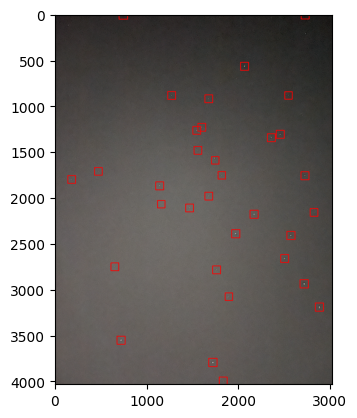

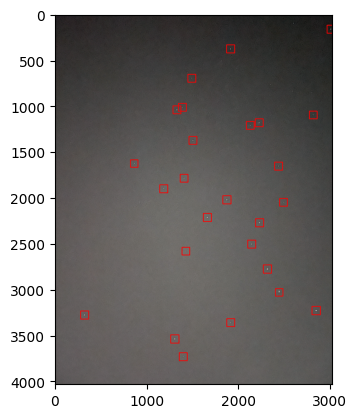

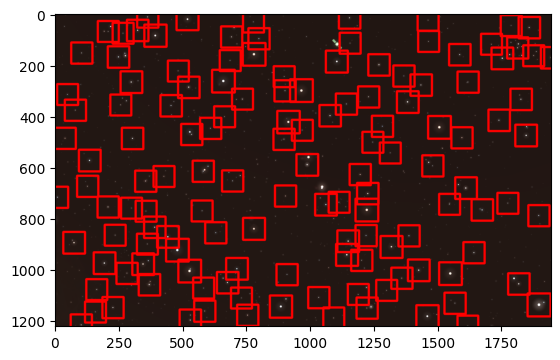

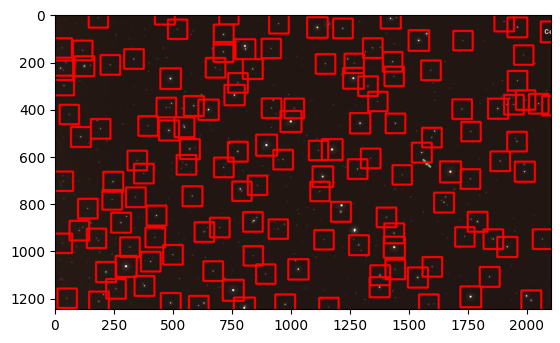

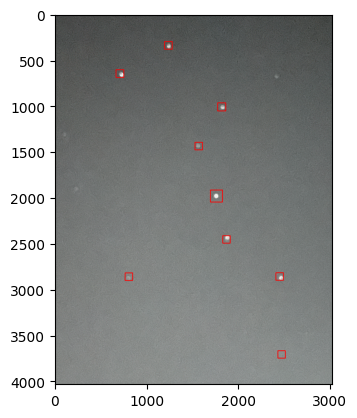

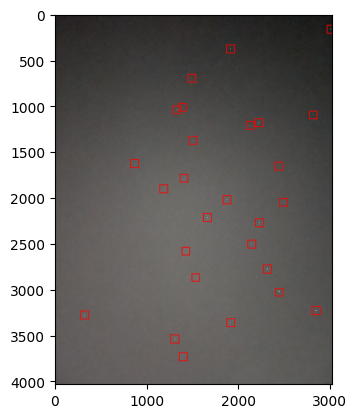

In [66]:

"""
Main that output the coordinates of the Imgs test at boaz_data_test folder

output_folder = "output_boaz_data_test"
"""

# Folder paths
input_folder =  '/content/drive/MyDrive/EX1/Ex1/boaz_data_test'
output_folder =  '/content/drive/MyDrive/EX1/Ex1/output_boaz_data_test'


# Process all images in the folder and save coordinates
process_images_in_folder(input_folder, output_folder)

folder_path = '/content/drive/MyDrive/EX1/Ex1/boaz_data_test'

# List of image filenames
image_filenames = [
    "fr1.jpg",
    "fr2.jpg",
    "ST_db1.png",
    "ST_db2.png",

]

# Load images dynamically
images = [cv.imread(os.path.join(folder_path, filename)) for filename in image_filenames]

# Process each image
for img in images:
    if img is not None:  # Check if image is loaded successfully
        points = starsDetection(img)
        drawRectangles(img, points, (255, 0, 0))  # Draw rectangles on the image
        plt.imshow(img)  # Convert BGR to RGB for displaying with plt
        plt.show()
    else:
        print("❌ Failed to load one of the images.")



#MY TEST

folder_path = '/content/drive/MyDrive/EX1/Ex1/data_images'

# List of image filenames
image_filenames = [
    "IMG_3052.jpg",
    "IMG_3053.jpg",


]

# Load images dynamically
images = [cv.imread(os.path.join(folder_path, filename)) for filename in image_filenames]

# Process each image
for img in images:
    if img is not None:  # Check if image is loaded successfully
        points = starsDetection(img)
        drawRectangles(img, points, (255, 0, 0))  # Draw rectangles on the image
        plt.imshow(img)  # Convert BGR to RGB for displaying with plt
        plt.show()
    else:
        print("❌ Failed to load one of the images.")






# Q3 - Matching Imgs Examples


In [78]:
import os
from detection_stars import starsDetection, drawRectangles, findMatching, save_stars_to_txt, ransacLineFit
from functionForMain import process_images_in_folder
from secondWayMatching import findMatchingStars, showStars

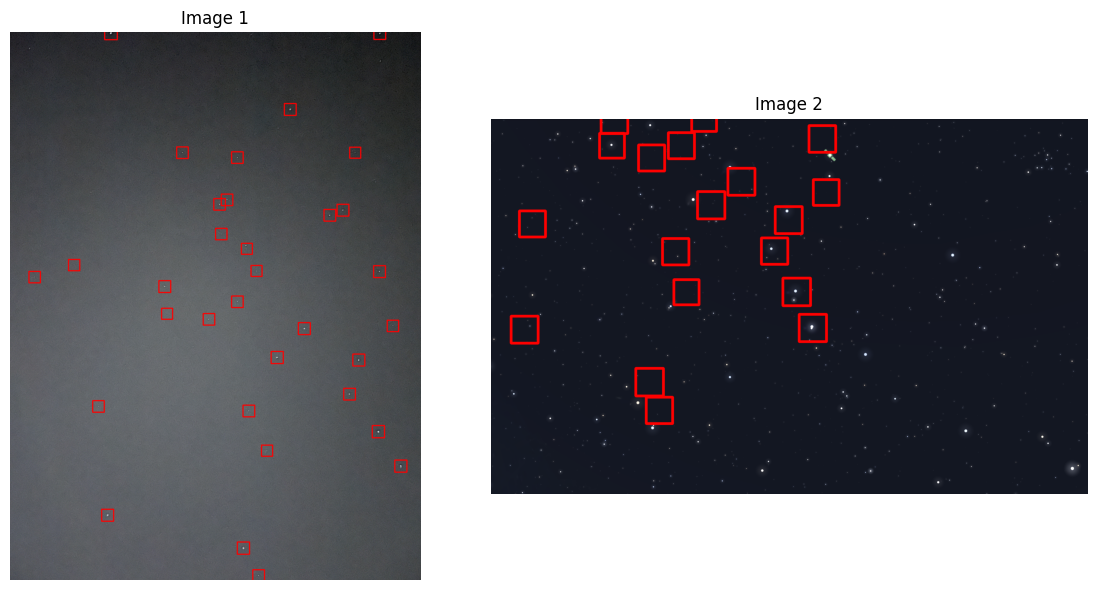

### Correlation ###
1826, 3996, 6, 215 => 545, 946, 6, 215
1712, 3792, 10, 251 => 511, 852, 10, 251
714, 3551, 8, 253 => 105, 682, 8, 253
2871, 3189, 9, 253 => 1043, 676, 9, 253
1890, 3079, 2, 181 => 635, 563, 2, 181
2705, 2935, 10, 243 => 990, 558, 10, 243
1754, 2785, 6, 242 => 598, 429, 6, 242
648, 2752, 5, 212 => 132, 339, 5, 212
2495, 2661, 6, 238 => 920, 427, 6, 238
2562, 2409, 8, 251 => 965, 325, 8, 251
1961, 2390, 9, 254 => 712, 276, 9, 254
2161, 2178, 8, 239 => 811, 200, 8, 239
2815, 2160, 4, 200 => 1089, 237, 4, 200
1461, 2111, 5, 250 => 520, 124, 5, 250
1155, 2072, 1, 183 => 393, 86, 1, 183
1670, 1982, 5, 253 => 617, 84, 5, 253
1135, 1869, 7, 239 => 398, 0, 7, 239
2715, 1759, 7, 224 => 1075, 61, 7, 224


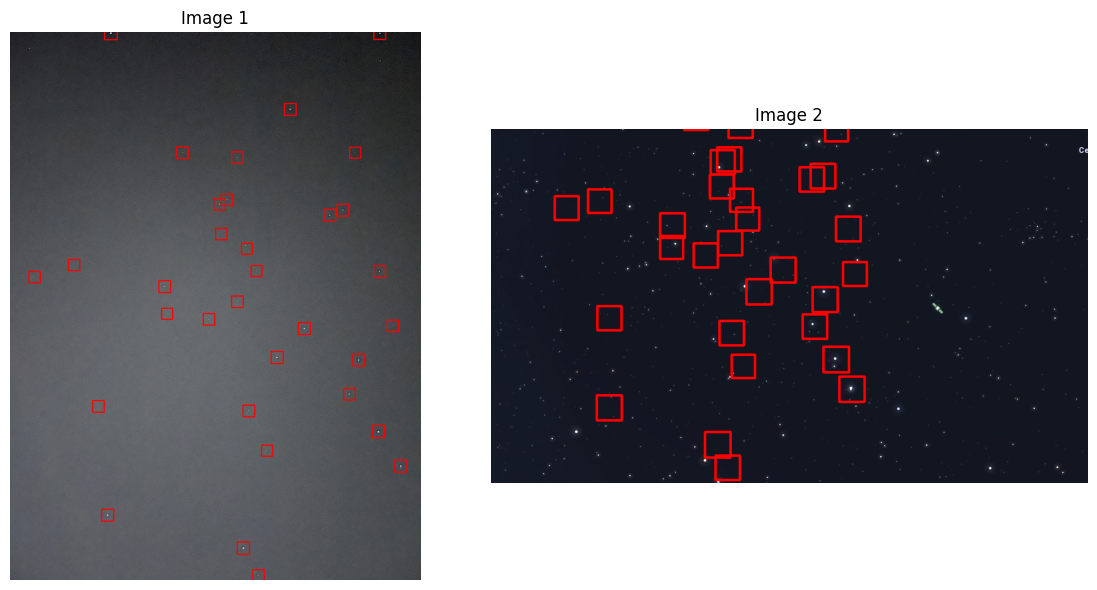

### Correlation ###
1826, 3996, 6, 215 => 830, 1189, 6, 215
1712, 3792, 10, 251 => 793, 1106, 10, 251
714, 3551, 8, 253 => 412, 977, 8, 253
2871, 3189, 9, 253 => 1266, 911, 9, 253
1890, 3079, 2, 181 => 887, 834, 2, 181
2705, 2935, 10, 243 => 1210, 806, 10, 243
1754, 2785, 6, 242 => 844, 715, 6, 242
648, 2752, 5, 212 => 414, 663, 5, 212
2495, 2661, 6, 238 => 1137, 692, 6, 238
2562, 2409, 8, 251 => 1172, 596, 8, 251
1961, 2390, 9, 254 => 939, 568, 9, 254
2161, 2178, 8, 239 => 1024, 492, 8, 239
2815, 2160, 4, 200 => 1279, 508, 4, 200
1461, 2111, 5, 250 => 753, 442, 5, 250
1155, 2072, 1, 183 => 635, 416, 1, 183
1670, 1982, 5, 253 => 839, 399, 5, 253
1135, 1869, 7, 239 => 635, 336, 7, 239
179, 1801, 4, 212 => 264, 276, 4, 212
2715, 1759, 7, 224 => 1254, 348, 7, 224
1813, 1757, 1, 182 => 903, 316, 1, 182
470, 1713, 3, 188 => 381, 252, 3, 188
1742, 1594, 1, 180 => 881, 250, 1, 180
1552, 1484, 4, 189 => 810, 200, 4, 189
2350, 1345, 6, 244 => 1126, 174, 6, 244
2446, 1307, 7, 246 => 1165, 162, 7

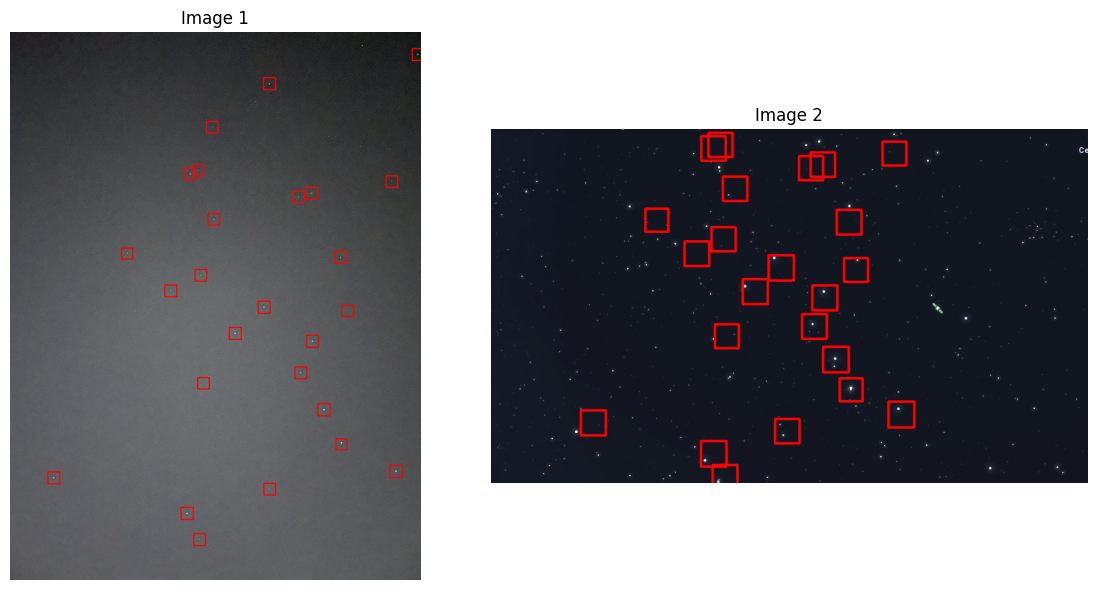

### Correlation ###
1391, 3731, 7, 192 => 820, 1222, 7, 192
1298, 3536, 10, 251 => 779, 1138, 10, 251
1908, 3360, 6, 210 => 1040, 1060, 6, 210
318, 3276, 8, 252 => 356, 1030, 8, 252
2835, 3226, 11, 255 => 1439, 999, 11, 255
2438, 3033, 1, 182 => 1267, 917, 1, 182
2305, 2774, 10, 252 => 1209, 806, 10, 252
1421, 2582, 4, 241 => 828, 727, 4, 241
2136, 2504, 7, 246 => 1135, 691, 7, 246
2221, 2271, 8, 249 => 1171, 590, 8, 249
1653, 2213, 8, 255 => 926, 568, 8, 255
2483, 2050, 4, 216 => 1283, 494, 4, 216
1865, 2020, 9, 249 => 1017, 484, 9, 249
1179, 1901, 7, 247 => 721, 435, 7, 247
1401, 1787, 5, 246 => 816, 385, 5, 246
2428, 1654, 7, 250 => 1257, 324, 7, 250
861, 1629, 1, 189 => 583, 320, 1, 189
1497, 1374, 6, 254 => 856, 207, 6, 254
2121, 1211, 5, 231 => 1124, 135, 5, 231
2218, 1182, 6, 241 => 1165, 122, 6, 241
2807, 1098, 4, 206 => 1418, 84, 4, 206
1323, 1041, 6, 254 => 780, 65, 6, 254
1383, 1014, 5, 244 => 805, 53, 5, 244


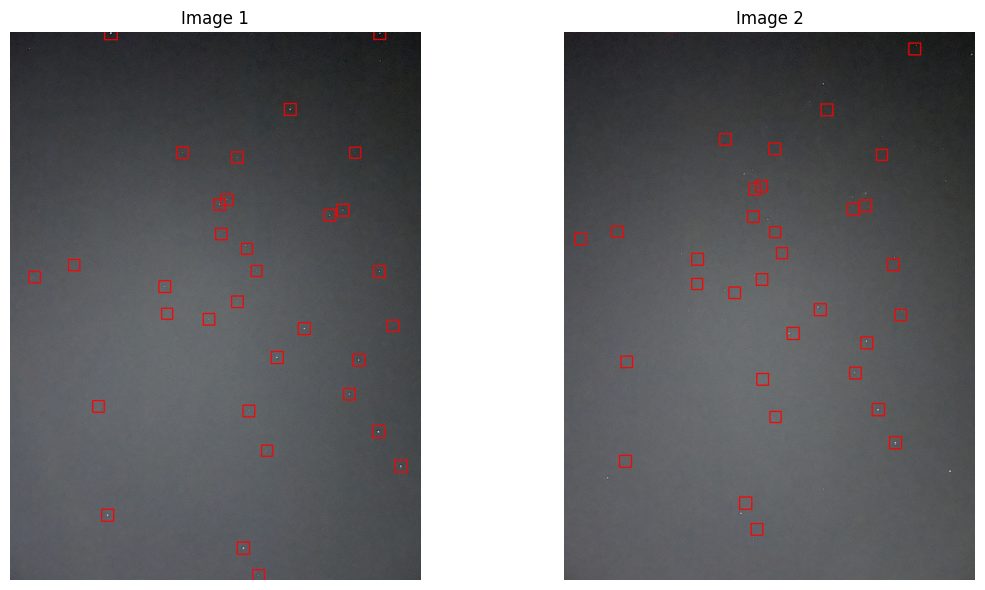

### Correlation ###
1826, 3996, 6, 215 => 1416, 3656, 6, 215
1712, 3792, 10, 251 => 1331, 3461, 10, 251
714, 3551, 8, 253 => 448, 3154, 8, 253
2871, 3189, 9, 253 => 2434, 3017, 9, 253
1890, 3079, 2, 181 => 1555, 2831, 2, 181
2705, 2935, 10, 243 => 2307, 2773, 10, 243
1754, 2785, 6, 242 => 1458, 2552, 6, 242
648, 2752, 5, 212 => 459, 2424, 5, 212
2495, 2661, 6, 238 => 2141, 2506, 6, 238
2562, 2409, 8, 251 => 2224, 2283, 8, 251
1961, 2390, 9, 254 => 1681, 2213, 9, 254
2161, 2178, 8, 239 => 1881, 2039, 8, 239
2815, 2160, 4, 200 => 2475, 2080, 4, 200
1461, 2111, 5, 250 => 1253, 1916, 5, 250
1155, 2072, 1, 183 => 979, 1853, 1, 183
1670, 1982, 5, 253 => 1454, 1818, 5, 253
1135, 1869, 7, 239 => 979, 1668, 7, 239
179, 1801, 4, 212 => 119, 1521, 4, 212
2715, 1759, 7, 224 => 2420, 1708, 7, 224
1813, 1757, 1, 182 => 1603, 1626, 1, 182
470, 1713, 3, 188 => 390, 1467, 3, 188
1742, 1594, 1, 180 => 1553, 1472, 1, 180
1552, 1484, 4, 189 => 1391, 1356, 4, 189
2350, 1345, 6, 244 => 2126, 1301, 6, 244
24

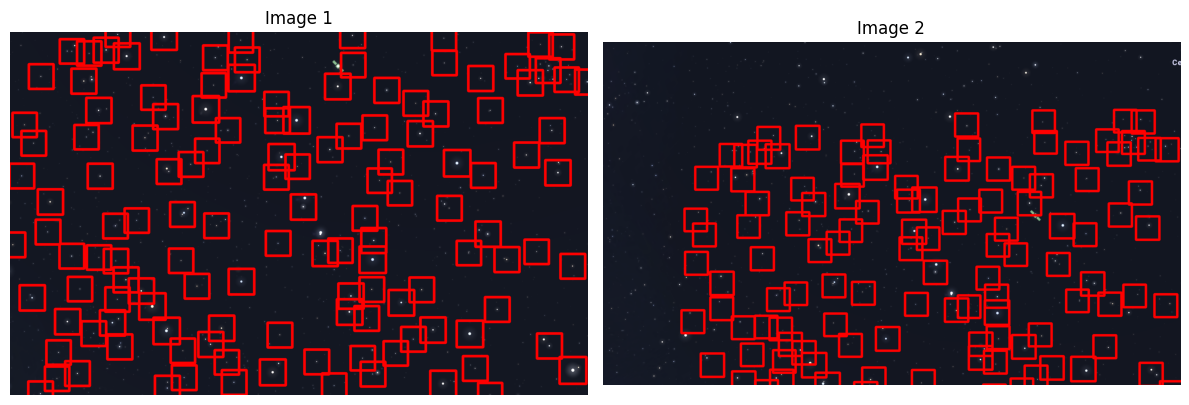

### Correlation ###
1614, 1221, 1, 202 => 1821, 1369, 1, 202
101, 1216, 3, 240 => 443, 1463, 3, 240
527, 1197, 4, 227 => 830, 1418, 4, 227
1089, 1189, 2, 187 => 1341, 1374, 2, 187
1453, 1180, 7, 255 => 1672, 1342, 7, 255
752, 1178, 3, 217 => 1033, 1386, 3, 217
157, 1166, 2, 158 => 491, 1414, 2, 158
584, 1162, 3, 194 => 879, 1383, 3, 194
1219, 1150, 3, 188 => 1457, 1330, 3, 188
225, 1148, 3, 253 => 551, 1393, 3, 253
880, 1142, 7, 255 => 1148, 1345, 7, 255
1888, 1134, 10, 255 => 2065, 1272, 10, 255
1563, 1131, 3, 203 => 1769, 1290, 3, 203
728, 1111, 2, 184 => 1007, 1327, 2, 184
1030, 1109, 3, 223 => 1282, 1305, 3, 223
1185, 1097, 2, 202 => 1422, 1284, 2, 202
1296, 1081, 2, 193 => 1522, 1262, 2, 193
162, 1078, 2, 255 => 489, 1334, 2, 255
580, 1072, 2, 184 => 870, 1301, 2, 184
367, 1058, 4, 255 => 675, 1302, 4, 255
1812, 1055, 4, 255 => 1991, 1205, 4, 255
673, 1050, 4, 255 => 953, 1275, 4, 255
1355, 1033, 3, 200 => 1573, 1215, 3, 200
906, 1019, 3, 195 => 1163, 1231, 3, 195
280, 1014, 3, 20

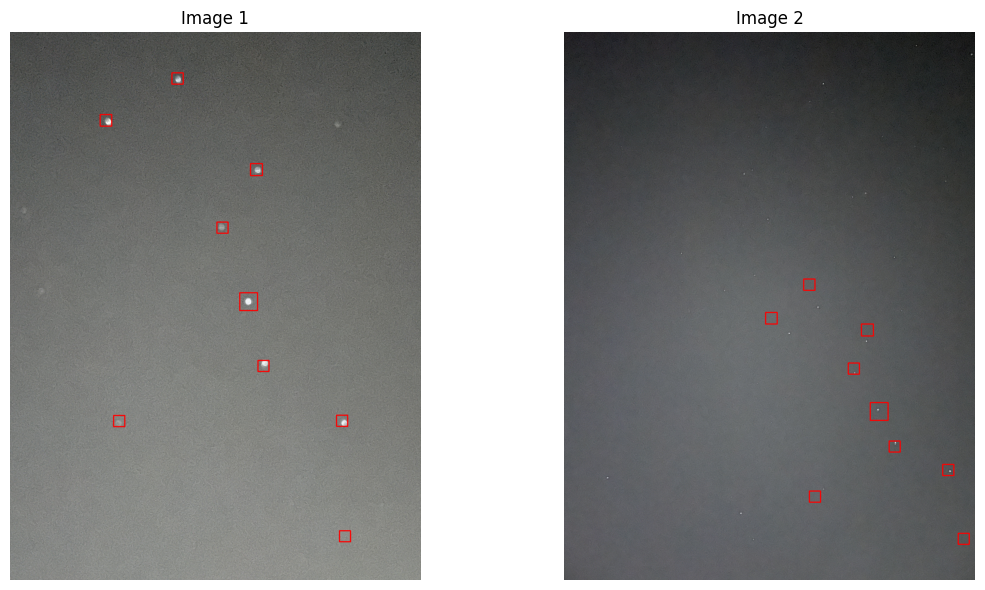

### Correlation ###
2464, 3709, 1, 180 => 2940, 3728, 1, 180
802, 2861, 2, 183 => 1845, 3417, 2, 183
2442, 2859, 2, 183 => 2826, 3221, 2, 183
1864, 2456, 1, 180 => 2432, 3049, 1, 180
1730, 1958, 51, 247 => 2293, 2766, 51, 247
1562, 1438, 2, 180 => 2131, 2475, 2, 180
1809, 1008, 8, 191 => 2228, 2188, 8, 191
703, 647, 5, 178 => 1523, 2103, 5, 178
1231, 340, 3, 183 => 1803, 1857, 3, 183


In [96]:

"""
Main of Matching stars - detections_stars

Ransac Algo

"""


#matching stars
findMatching('/content/drive/MyDrive/EX1/Ex1/boaz_data_test/fr1.jpg', '/content/drive/MyDrive/EX1/Ex1/boaz_data_test/ST_db1.png')
findMatching('/content/drive/MyDrive/EX1/Ex1/boaz_data_test/fr1.jpg', '/content/drive/MyDrive/EX1/Ex1/boaz_data_test/ST_db2.png')
findMatching('/content/drive/MyDrive/EX1/Ex1/boaz_data_test/fr2.jpg', '/content/drive/MyDrive/EX1/Ex1/boaz_data_test/ST_db2.png')
findMatching('/content/drive/MyDrive/EX1/Ex1/boaz_data_test/fr1.jpg', '/content/drive/MyDrive/EX1/Ex1/boaz_data_test/fr2.jpg')
findMatching('/content/drive/MyDrive/EX1/Ex1/boaz_data_test/ST_db1.png', '/content/drive/MyDrive/EX1/Ex1/boaz_data_test/ST_db2.png')
findMatching('/content/drive/MyDrive/EX1/Ex1/data_images/IMG_3052.jpg', '/content/drive/MyDrive/EX1/Ex1/data_images/IMG_3053.jpg')

#findMatching('/content/drive/MyDrive/EX1/Ex1/boaz_data_test/fr2.jpg', '/content/drive/MyDrive/EX1/Ex1/boaz_data_test/ST_db1.png')
#findMatching('/content/drive/MyDrive/EX1/Ex1/boaz_data_test/fr2.jpg', '/content/drive/MyDrive/EX1/Ex1/boaz_data_test/fr1.jpg')
#findMatching('/content/drive/MyDrive/EX1/Ex1/boaz_data_test/ST_db1.png', '/content/drive/MyDrive/EX1/Ex1/boaz_data_test/fr1.jpg')
#findMatching('/content/drive/MyDrive/EX1/Ex1/boaz_data_test/ST_db1.png', '/content/drive/MyDrive/EX1/Ex1/boaz_data_test/fr2.jpg')

#findMatching('/content/drive/MyDrive/EX1/Ex1/boaz_data_test/ST_db2.png', '/content/drive/MyDrive/EX1/Ex1/boaz_data_test/fr1.jpg')
#findMatching('/content/drive/MyDrive/EX1/Ex1/boaz_data_test/ST_db2.png', '/content/drive/MyDrive/EX1/Ex1/boaz_data_test/fr2.jpg')
#findMatching('/content/drive/MyDrive/EX1/Ex1/boaz_data_test/ST_db2.png', '/content/drive/MyDrive/EX1/Ex1/boaz_data_test/ST_db1.png')

